In [1]:
%load_ext cython

In [2]:
import numpy as np
import pyemma
import matplotlib
import matplotlib.pyplot as plt
import pyemma.plots as mplt
import math
import h5py
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (7.0, 7.0)
plt.rc('text', usetex='True')
plt.rc('font', family='serif')

In [3]:
def discreteHistogram(data):
    d = np.diff(np.unique(data)).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    hist = plt.hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d))
    centers = (hist[1][1:] + hist[1][:-1])/2
    return hist, centers

In [4]:
%%cython
import numpy as np
cimport numpy as np
from multiprocessing import Pool
cdef extern from "math.h":
    double atan2(double y, double x)
    
cdef double PI = np.pi

cdef class trajDiscretizationCython:
    cdef object centers
    cdef public double innerMSMrad, bathRadOut, radialIncrementEntry, radialIncrementExit, radialIncrementBath
    cdef public int angularPartitions, entryRings, exitRings, bathRings, radialPartitions, Ncenters, Nstates, bathIndex
    def __init__(self, np.ndarray[double, ndim=2] centers):
        self.centers = centers
        self.innerMSMrad = 2.0
        self.angularPartitions = 48
        self.Ncenters = len(self.centers)
        self.Nstates = self.Ncenters + self.angularPartitions + 1
        
    cpdef int getAngularState(self, np.ndarray[double, ndim=1] coord):
        cdef double theta = atan2(coord[1], coord[0]) + PI
        cdef int angularState = int(theta*self.angularPartitions/(2*PI))
        return angularState
    
    # Overwrite getState function in parent class
    #discretize trajectory: use two additional rings of states for entry and exit states
    #cluster volume should be on the same order of magnitute as for the internal states
    
    cdef int getState(self, np.ndarray[double, ndim=1] coord, int prevst):
        cdef double radius = np.linalg.norm(coord)
        cdef np.ndarray[double, ndim=2] cen2coord
        cdef np.ndarray[double, ndim=1] norm
        cdef int index
        # inner MSM
        if radius < self.innerMSMrad:
            for index in range(self.Ncenters):
                if (self.centers[index][0] - coord[0])**2 + (self.centers[index][1] - coord[1])**2 < 0.04:
                    return index
            return prevst
        else:
            angularState = self.getAngularState(coord)
            return self.Ncenters + angularState

    cpdef getdTraj(self, np.ndarray[double, ndim=2] traj):
        cdef int k, checker,i 
        cdef np.ndarray[long, ndim=1] dTraj
        # skip first elements, that might have udefined behavior.
        k = 0
        checker = self.getState(traj[0], -1)
        while checker < 0:
            k += 1
            checker = self.getState(traj[k], -1)
        dTraj = np.zeros(len(traj)-k, dtype=int)
        dTraj[0] = checker
        for i in range(1, len(traj)-k):
            dTraj[i] = self.getState(traj[i+k], dTraj[i-1])
        return dTraj
    
    cpdef getdTrajs(self, list trajs):
        cdef np.ndarray[double, ndim=2] traj
        cdef list dTrajs = []
        cdef int k, checker,i 
        for traj in trajs:
            dTrajs.append(self.getdTraj(traj))
        return dTrajs
    
    cpdef getTruncatedTrajs(self, list trajs):
        cdef list innerTrajs = []
        cdef list currentTraj
        cdef bint trajActive = False
        cdef bint innerTrajActive = False
        cdef np.ndarray[double, ndim=1] norm
        cdef int length
        for traj in trajs:
            norm = np.linalg.norm(traj, axis = 1)
            trajActive = False
            innerTrajActive = False
            length = len(traj)
            for i in range(0, length):
                if not trajActive:
                    if norm[i]<self.innerMSMrad:
                        #Start a new truncated trajectory. Maybe add previous state!
                        trajActive = True
                        if i > 0:
                            currentTraj = [traj[i-1], traj[i]]
                        else:
                            currentTraj = [traj[i]]
                else:
                    if norm[i] > self.innerMSMrad:
                        trajActive = False
                        currentTraj.append(traj[i])
                        innerTrajs.append(np.array(currentTraj))
                    else:
                        currentTraj.append(traj[i])
        return innerTrajs
    
    cpdef getCountMatrix(self, list dTrajs, int lagtime):
        #compute Count matrix from truncated trajectories.
        #if the lenght of a trajectory is shorter than the lagtime:
        #count event
        cdef np.ndarray[long, ndim=2] C = np.zeros([self.Nstates, self.Nstates], dtype=int)
        cdef np.ndarray[long, ndim=1] dTraj
        for dTraj in dTrajs:
            if len(dTraj) < lagtime:
                #C[dTraj[0], dTraj[-1]] += 1
                continue
            for i in range(len(dTraj) - lagtime):
                C[dTraj[i], dTraj[i+lagtime]] += 1
        return C
    
    cpdef getLookupTable(self, list dTrajs, list truncTrajs):
        cdef np.ndarray[long, ndim=1] dTraj
        cdef np.ndarray[double, ndim=1] truncTraj, entryCoord
        cdef int j, i, currentState, entryState
        cdef list entryCoords = []
        cdef list firstStates = []
        cdef list times = []
        for i in range(len(truncTrajs)):
            entryCoords.append(truncTrajs[i][1])
            entryState = dTrajs[i][0]
            j = 0
            currentState = entryState
            while currentState == entryState or j < len(dTrajs[i])-2:
                j += 1
                currentState = dTrajs[i][j]
            times.append(j)
            if currentState >= self.Ncenters:
                firstStates.append(truncTrajs[i][-1])
            else:
                firstStates.append(currentState)
        return entryCoords, firstStates, times

In [38]:
    def getLookupTable( dTrajs,  truncTrajs):
        entryCoords = []
        firstStates = []
        times = []
        Ncenters = 9
        innerMSMrad = 2.0
        for i in range(len(truncTrajs)):
            if np.linalg.norm(truncTrajs[i][0]) < innerMSMrad:
                continue
            entryCoords.append(truncTrajs[i][1])
            entryState = dTrajs[i][0]
            j = 0
            currentState = entryState
            while currentState == entryState and j < len(dTrajs[i])-2:
                j += 1
                currentState = dTrajs[i][j]
            times.append(j)
            if currentState >= Ncenters:
                firstStates.append(truncTrajs[i][-1])
            else:
                firstStates.append(currentState)
        return np.array(entryCoords), firstStates, times

In [5]:
numfiles = 1
# Extract trajectories from file using asym2Dtraj class
fname = '../data/asym2D/ring/2DasymTrajsLong_R4_RT1E7_dt001_SI10_'
dimension = 2
trajs = []
for number in range(numfiles):
    f = h5py.File(fname + str(number) + '.h5', 'r')
    data = np.array(f['traj'], dtype=float)
    f.close()
    if not np.allclose(data[1:,0]-data[:-1,0], 10):
        print 'timestep not constant'
    traj = data[:,1:dimension+1]
    trajs.append(traj)

In [6]:
minima = [[0.0,0.0], [1.0,0.0] , [1.1, 1.0], [-0.1,0.9], [-1.3,0.8], \
                       [-1.0,-0.2], [-0.6,-1.0], [0.9,-0.8], [0.2,-1.5]]
discretizer = trajDiscretizationCython(np.array(minima))

In [7]:
%%time
truncTrajs = discretizer.getTruncatedTrajs(trajs)

CPU times: user 236 ms, sys: 0 ns, total: 236 ms
Wall time: 233 ms


In [8]:
dTrajs = discretizer.getdTrajs(truncTrajs)

In [39]:
entryCoords, firstStates, times = getLookupTable(dTrajs, truncTrajs)

In [40]:
print entryCoords[:]

[[-1.62505603 -0.96856338]
 [-1.6248188  -1.16613698]
 [-1.97345984  0.10516591]
 ..., 
 [-1.08757973 -1.50611436]
 [-1.42556381  1.35270929]
 [-1.42902875  1.18879092]]


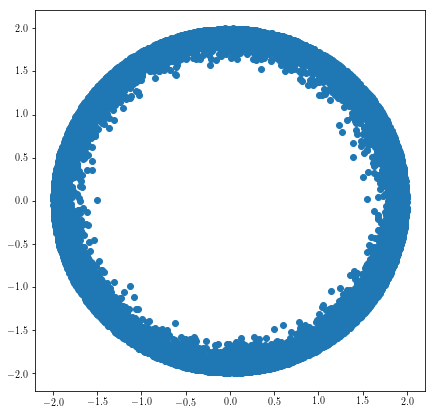

In [42]:
plt.scatter(entryCoords[:,0], entryCoords[:,1])

In [46]:
coords = []
for coord in firstStates:
    if not np.isscalar(coord):
        coords.append(coord)

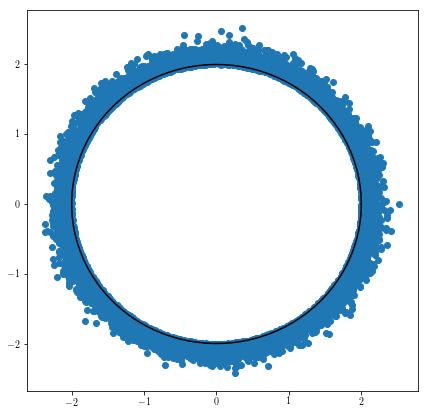

In [54]:
coords = np.array(coords)
plt.scatter(coords[:,0], coords[:,1])
theta = np.linspace(0, 2*np.pi, 100)
x = 2.*np.cos(theta)
y = 2.*np.sin(theta)
plt.plot(x,y, 'k')

In [57]:
states = []
for state in firstStates:
    if np.isscalar(state):
        states.append(state)

((array([  63.,  209.,  546.,  213.,  472.,  207.,  294.,  331.,  479.]),
  array([-0.5,  0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5]),
  <a list of 9 Patch objects>),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.]))

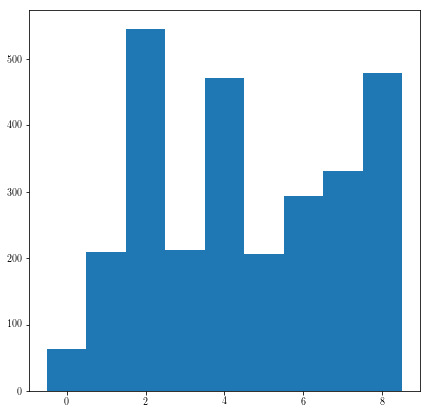

In [58]:
discreteHistogram(np.array(states))

(-2, 2)

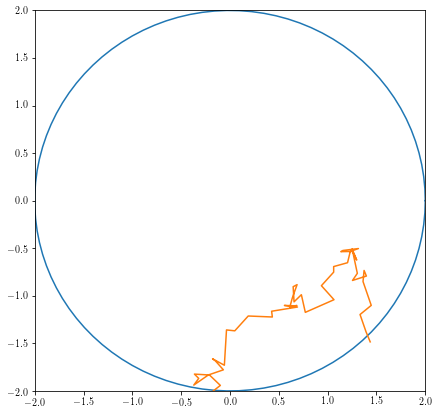

In [50]:
trajnr = 25
theta = np.linspace(0, 2*np.pi, 100)
x = 2.*np.cos(theta)
y = 2.*np.sin(theta)
plt.plot(x,y)
plt.plot(truncTrajs[trajnr][:,0], truncTrajs[trajnr][:,1])
plt.xlim(-2,2)
plt.ylim(-2,2)

In [122]:
lengths = []
for traj in truncTrajs:
    lengths.append(len(traj))

(0, 20)

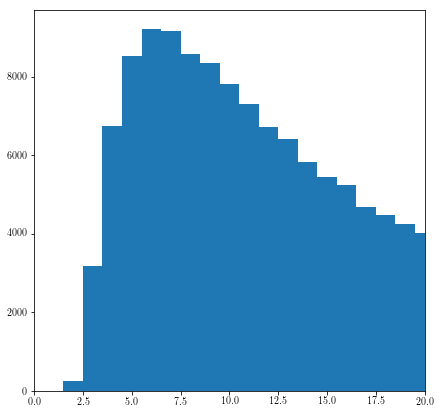

In [123]:
hist = discreteHistogram(np.array(lengths))
plt.xlim((0,20))

In [124]:
%%time
truncDTrajs = discretizer.getdTrajs(truncTrajs)

CPU times: user 3min 13s, sys: 208 ms, total: 3min 13s
Wall time: 3min 13s


In [125]:
truncDTrajs[0].dtype

dtype('int64')

In [126]:
C = discretizer.getCountMatrix(truncDTrajs, 10)

In [127]:
T = C.astype(float)

In [128]:
#set direct transitions from inner states to bath to zero
for i in range(9):
    T[i,-1] = 0
#normalize in order to get a stochastic matrix
for i in range(T.shape[0]-1):
    T[i,:] /= np.sum(T[i,:])

In [129]:
#Prepare data to be extracted to file
#For this we need the position of the cluster centers as well as the information about the angles of the exit states
class MSMmodel(object):    
    def __init__(self, tmatrix, centers, parameters):
        self.tmatrix = tmatrix
        self.centers= centers
        self.parameters = parameters
parameters = {}
parameters['interactionRadius'] = discretizer.innerMSMrad
parameters['entryRadius'] = discretizer.entryRad
parameters['bathRadius'] = discretizer.bathRad
parameters['outerBathRadius'] = discretizer.bathRadOut
parameters['NCenters'] = discretizer.Ncenters
parameters['NangularPartitions'] = discretizer.angularPartitions
parameters['entryRings'] = discretizer.entryRings
parameters['exitRings'] = discretizer.exitRings
parameters['lagtime'] = 10
model = MSMmodel(T, minima, parameters)

In [130]:
import pickle
pickle.dump(model, open('../data/models/asym2D/1radial48angular10lag_entryToExit.p', 'wa'))

In [113]:
modelRe = pickle.load(open('../data/models/asym2D/1radial48angular10lag_entryToExit.p', 'r'))

In [114]:
modelRe.tmatrix

array([[  7.24589876e-01,   4.88762354e-02,   1.23538855e-02, ...,
          0.00000000e+00,   6.27100788e-05,   0.00000000e+00],
       [  4.86420172e-02,   6.93987288e-01,   5.17351640e-02, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       [  1.91158901e-02,   6.51214656e-02,   6.56853843e-01, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00],
       ..., 
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          1.09560724e-01,   7.80361757e-02,   4.13436693e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          8.50855746e-02,   1.08557457e-01,   5.03667482e-02],
       [  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00]])

In [115]:
len(T)

106

In [117]:
9+2*48 +1 

106